## Generate data from sims.

In [1]:
from shared.preface import *
import shared.functions as fct

# Generate (phi, theta) coord. pairs based on desired healpy map.
Nside = 2**2              # Specify nside parameter
Npix = 12 * Nside**2      # Number of pixels
pix_sr = (4*np.pi)/Npix   # Pixel size  [sr]
print(f'Healpy parameters: Nside={Nside}, Npix={Npix}, pix_sr={pix_sr}')
hp_thetas, hp_phis = np.array(hp.pixelfunc.pix2ang(Nside, np.arange(Npix)))

# Initialize parameters and files.
PRE = PRE(
    sim='L012N376', 
    z0_snap=62, z4_snap=13, DM_lim=1000,
    sim_dir=SIM_ROOT, sim_ver=SIM_TYPE,
    phis=hp_phis, thetas=hp_thetas, vels=10000,
    pre_CPUs=96, sim_CPUs=128
)

mass_gauge = 12.3
mass_range = 0.3
size = 1
hname = f'1e+{mass_gauge}_pm{mass_range}Msun'
fct.halo_batch_indices(
    PRE.Z0_STR, mass_gauge, mass_range, 'halos', size, 
    hname, PRE.SIM_DIR, PRE.OUT_DIR
)
halo_batch_IDs = np.load(f'{PRE.OUT_DIR}/halo_batch_{hname}_indices.npy')
halo_batch_params = np.load(f'{PRE.OUT_DIR}/halo_batch_{hname}_params.npy')
halo_num = len(halo_batch_params)

print('********Number density band********')
print('Halo batch params (Rvir,Mvir,cNFW):')
print(halo_batch_params)
print('***********************************')

Healpy parameters: Nside=4, Npix=192, pix_sr=0.06544984694978735
********************* Initialization *********************
# Initial conditions for neutrinos:
PHIs = 192, THETAs=192, Vs=10000
Total neutrinos: 368640000
# Simulation parameters:
Simulation box: L012N376
Snapshot from 0062 (z=0) to 0013 (z=4)
Pre/Sim CPUs 96/128
DM limit for cells: 1000
# File management:
Box files directory: 
 /home/fabian/ownCloud/snellius/L012N376/DMONLY/CDM_TF50
Output directory: 
 /home/fabian/my_github_projects/neutrino_clustering_V2/L012N376/DMONLY/CDM_TF50
**********************************************************
********Number density band********
Halo batch params (Rvir,Mvir,cNFW):
[[299.54209457  12.45775108   8.69090077]]
***********************************


## All-sky map for 1 neutrino mass.

5.743818597706908


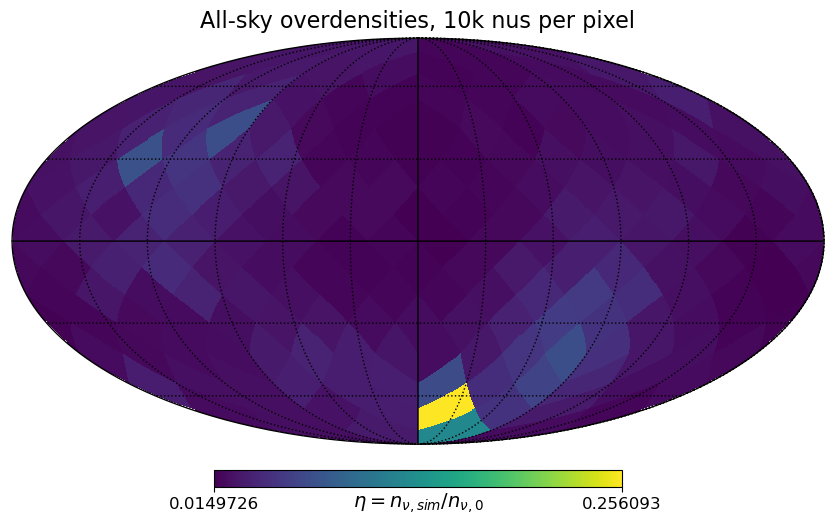

In [6]:
# Load local number densities for all pixels.
nu_mass_range = np.geomspace(0.01, 0.3, 100)*eV
mass_choice = np.where(nu_mass_range==0.3)[0][0]
etas_arr = np.zeros(Npix)
for i in range(Npix):
    CPname = f'{PRE.NUS}nus_{hname}_CoordPair{i+1}'
    out_file = f'{PRE.OUT_DIR}/number_densities_{CPname}.npy'
    etas_arr[i] = np.load(f'{out_file}')[mass_choice]/N0

print(np.sum(etas_arr))

hp.mollview(etas_arr, title='All-sky overdensities, 10k nus per pixel', unit=r'$\eta = n_{\nu, sim} / n_{\nu, 0}$')
hp.graticule()
plt.show()

## Tests.

In [ ]:
from shared.preface import *
import shared.functions as fct


# Read in all velocities for neutrinos.
PHIs = 10
THETAs = 10
Vs = 100
nus = 10000
sim = 'L012N376'
mass_gauge = 12.0  # in log10 Msun
mass_range = 0.46
halo_num = 1
halo_j = 4
batchname = f'1e+{mass_gauge}_pm{mass_range}Msun'
m_nu = 0.3*eV

hname = f'{batchname}_halo{halo_j}'
fname = f'{nus}nus_{hname}'
u_all = fct.load_sim_data(sim, fname, 'velocities')

# Convert to momenta for chosen m_nu and get "Fermi-Dirac weights".
p, _ = fct.u_to_p_eV(u_all, m_nu)
p0, p1 = p[:,0], p[:,-1]
FD_weights = p0**2 * fct.Fermi_Dirac(p1)

# The number density at coords. (phi, theta) in the sky is the integral over 
# all momenta with that coord. pair.
p0_pairs = np.reshape(p0, (-1, Vs))
p1_pairs = np.reshape(p1, (-1, Vs))

ODs = np.zeros(len(p0_pairs))
for i, (p0s_pair, p1s_pair) in enumerate(zip(p0_pairs, p1_pairs)):
    ODs[i] = fct.number_density(p0s_pair, p1s_pair)/N0

eps = 0.01  # shift in theta, so poles are not included
ts = np.linspace(0.+eps, Pi-eps, THETAs)
ps = np.linspace(0., 2.*Pi, PHIs)

Nside = 2**3              # Specify nside parameter
Npix = 12 * Nside**2      # Number of pixels
pix_sr = (4*np.pi)/Npix   # Pixel size  [sr]
print(f'Healpy parameters: Nside={Nside}, Npix={Npix}, pix_sr={pix_sr}')

# Pixel index for each coord.
pix_IDs = np.array(
    [hp.pixelfunc.ang2pix(Nside, theta=t, phi=p) for t in ts for p in ps]
)
# print(pix_IDs, len(pix_IDs))

mollview_arr = np.zeros(Npix)
for pix in range(Npix):

    if np.any(pix == pix_IDs):
        vals_for_pix = ODs[np.where(pix == pix_IDs)]
        OD_pix = np.mean(vals_for_pix)
        mollview_arr[pix] = OD_pix 
    else:
        continue

# Gaussian smoothing
# moll_smooth = hp.sphtfunc.smoothing(mollview_arr, sigma=1)

hp.mollview(mollview_arr, title='', unit='')
hp.graticule()
plt.show()

# Mask poles.
mollview_arr[:15] = 0.0
mollview_arr[-15:] = 0.0
hp.mollview(mollview_arr, title='Masked Poles', unit='')
hp.graticule()
plt.show()

The standard coordinates are the colatitude $\theta$, 0 at the North Pole, $\pi / 2$ at the equator and $\pi$ at the South Pole and the longitude $\phi$ between 0 and $2 \pi$ eastward, in a Mollview projection, $\phi = 0$ is at the center and increases toward the left, then wraps around and comes from the right towards the center again.

In [ ]:
vec = hp.ang2vec(np.pi / 2, 1.8*Pi)
print(vec)
ipix_disc = hp.query_disc(nside=32, vec=vec, radius=np.radians(10))
m = np.arange(12288)
m[ipix_disc] = m.max()
hp.mollview(m, title="Mollview image RING")

In [ ]:
from shared.preface import *
import shared.functions as fct

# Load data for MW halo only.
nus = 10000
MW_HALO = True
VC_HALO = False
AG_HALO = False
halos = 'MW'*MW_HALO + '+VC'*VC_HALO + '+AG'*AG_HALO
sim = 'LinfNinf'
fname = f'nus_{nus}_halos_{halos}_{SOLVER}'
u_all = fct.load_sim_data(sim, fname, 'velocities')
m_nu = 0.3*eV

# Convert to momenta for chosen m_nu and get "Fermi-Dirac weights".
p, _ = fct.u_to_p_eV(u_all, m_nu)
p0, p1 = p[:,0], p[:,-1]
FD_weights = p0**2 * fct.Fermi_Dirac(p1)
 
# The number density at coords. (phi, theta) in the sky is the integral over 
# all momenta with that coord. pair.
p0_pairs = np.reshape(p0, (-1, Vs))
p1_pairs = np.reshape(p1, (-1, Vs))
print(p0_pairs.shape)

ODs = np.zeros(len(p0_pairs))
for i, (p0s_pair, p1s_pair) in enumerate(zip(p0_pairs, p1_pairs)):
    ODs[i] = fct.number_density(p0s_pair, p1s_pair)/N0

eps = 0.01  # shift in theta, so poles are not included
ts = np.linspace(0.+eps, Pi-eps, THETAs)
ps = np.linspace(0., 2.*Pi, PHIs)

Nside = 2**2              # Specify nside parameter
Npix = 12 * Nside**2      # Number of pixels
print(Npix)
pix_sr = (4*np.pi)/Npix   # Pixel size  [sr]

# Pixel index for each coord.
pix_IDs = np.array(
    [hp.pixelfunc.ang2pix(Nside, phi=p, theta=t) for p in ps for t in ts]
)
# print(pix_IDs, len(pix_IDs))

mollview_arr = np.zeros(Npix)
for pix in range(Npix):

    if np.any(pix == pix_IDs):
        vals_for_pix = ODs[np.where(pix == pix_IDs)]
        OD_pix = np.mean(vals_for_pix)
        mollview_arr[pix] = OD_pix 
    else:
        continue

# Mask poles.
mollview_arr[:15] = 0.0
mollview_arr[-15:] = 0.0

hp.mollview(mollview_arr, title='Smooth sim, 10000 neutrinos', unit='',
cmap='Blues')
hp.graticule()
plt.show()

In [ ]:
from shared.preface import *
import shared.functions as fct


# Read in all velocities for neutrinos.
PHIs = 10
THETAs = 10
Vs = 100
nus = 10000
sim = 'L012N376'
mass_gauge = 12.0  # in log10 Msun
mass_range = 0.46
halo_num = 10
batchname = f'1e+{mass_gauge}_pm{mass_range}Msun'
m_nu = 0.01*eV

ODs_halos = []
for halo_j in range(halo_num):

    hname = f'{batchname}_halo{halo_j}'
    fname = f'{nus}nus_{hname}'
    u_all = fct.load_sim_data(sim, fname, 'velocities')

    # Convert to momenta for chosen m_nu and get "Fermi-Dirac weights".
    p, _ = fct.u_to_p_eV(u_all, m_nu)
    p0, p1 = p[:,0], p[:,-1]
    FD_weights = p0**2 * fct.Fermi_Dirac(p1)

    # The number density at coords. (phi, theta) in the sky is the integral 
    # over all momenta with that coord. pair.
    p0_pairs = np.reshape(p0, (-1, Vs))
    p1_pairs = np.reshape(p1, (-1, Vs))

    # Overdensities (ODs).
    ODs = np.zeros(len(p0_pairs))
    for i, (p0s_pair, p1s_pair) in enumerate(zip(p0_pairs, p1_pairs)):
        ODs[i] = fct.number_density(p0s_pair, p1s_pair)/N0
    ODs_halos.append(ODs)
ODs_halos = np.array(ODs_halos)


eps = 0.01  # shift in theta, so poles are not included
ts = np.linspace(0.+eps, Pi-eps, THETAs)
ps = np.linspace(0., 2.*Pi, PHIs)

Nside = 2**2              # Specify nside parameter
Npix = 12 * Nside**2      # Number of pixels
pix_sr = (4*np.pi)/Npix   # Pixel size  [sr]

# Pixel index for each coord.
pix_IDs = np.array(
    [hp.pixelfunc.ang2pix(Nside, theta=t, phi=p) for t in ts for p in ps]
)
# print(pix_IDs, len(pix_IDs))

all_sky_halos = []
for ODs in ODs_halos:

    all_sky_halo = np.zeros(Npix)
    for pix in range(Npix):

        if np.any(pix == pix_IDs):
            vals_for_pix = ODs[np.where(pix == pix_IDs)]
            OD_pix = np.mean(vals_for_pix)
            all_sky_halo[pix] = OD_pix 
        else:
            continue
    all_sky_halos.append(all_sky_halo)
all_sky_halos = np.array(all_sky_halos)

all_sky_mean = np.mean(all_sky_halos, axis=0)
all_sky_median = np.median(all_sky_halos, axis=0)

# Mask poles.
all_sky_mean[:15] = 0.0
all_sky_mean[-15:] = 0.0

# all_sky_median[:15] = 0.0
# all_sky_median[-15:] = 0.0


hp.mollview(all_sky_mean, title='', unit='')
hp.graticule()